In [38]:
import pandas as pd
from os import listdir
import numpy as np
import random
import scipy.optimize as opt
import warnings
from Vasicek_one_factor import simulate_Vasicek_One_Factor
warnings.filterwarnings("ignore")

# Data

In [39]:
mypath = "Final"
data_list = listdir(mypath)

In [40]:
data = pd.DataFrame()
for col in data_list:
    tmp = pd.read_csv('Final/'+col, index_col = 'Date')
    data = pd.concat([data,tmp])
data.index = pd.DatetimeIndex(data.index)
df = pd.DataFrame(data.sort_index()['3 Mo'].copy())

In [41]:
df['3 Mo_shift'] = df['3 Mo'].shift(1) 
df['diff'] = df['3 Mo'] - df['3 Mo_shift']

In [42]:
db = df.dropna().copy()

# 估參數：k, theta , sigma

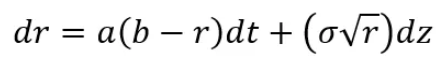

In [43]:
global N
N = 252
dt = 1/N
def fun_MLE(x): 
    
    random.seed(108)
    np.random.seed(108)
    # scipy
    DF = db_tmp.to_numpy()
    
    r0 = DF[:,0]
    r1 = DF[:,1]
    dr = DF[:,2]

    mu, sigma = 0, dt # mean and standard deviation
    s = np.random.normal(mu, sigma, len(DF))
    a = x[0]
    b = x[1]
    sigma = x[2]
    fit_dr =  a*(b-r0)*dt + sigma*np.sqrt(r0)*s
    error = np.sum(np.abs(fit_dr-dr))
    target = -np.log(error)
    # target = -error
    return target

In [44]:
initial = (0.3,0.3,0.3)
tmp = 0.1
constraints = ( 
                # {'type':'ineq','fun':lambda x : 2*x[0]*x[1]-x[2]**2},
                {'type':'ineq','fun':lambda x : x[2]},
                {'type':'ineq','fun':lambda x : -x[0]+1*tmp},
                {'type':'ineq','fun':lambda x : -x[1]+1*tmp},
                {'type':'ineq','fun':lambda x : -x[2]+1*tmp},
                {'type':'ineq','fun':lambda x : x[0]+1*tmp},
                {'type':'ineq','fun':lambda x : x[1]+1*tmp},
                {'type':'ineq','fun':lambda x : x[2]+1*tmp},
                )
# parameters = opt.minimize(fun_MLE, initial, method = 'SLSQP', constraints = constraints)
# bp = parameters['x']

# CIR

In [45]:
from CIR import CIR
import matplotlib.pyplot as plt

def estimate(bp,r0, period = 2):
    # assume mean-reverted speed = 1, mean-reverted level = 0.05, vol of interest rate = 0.05, initial interest rate = 0.05, and pass to an object named C
    V = simulate_Vasicek_One_Factor(r0, bp[0], bp[1], bp[2], dt*period, dt) 

    return np.array(V.iloc[1:])



In [46]:
ROLLING = 90 #調整參數週期
dates = db[::ROLLING].index
period = 90 # 預測下一期
global db_tmp


In [47]:
bps = []
for i in range(1,len(dates)):
    db_tmp = db[((db.index < dates[i]) & (db.index >= dates[i-1]))]
    parameters = opt.minimize(fun_MLE, initial, method = 'SLSQP', constraints = constraints)
    bp = parameters['x']
    bps.append(bp)

In [48]:
df_pa = pd.DataFrame(bps, columns = ['a','b','sigma'],index = dates[1:])
df_pa_me =  pd.merge(df, df_pa, left_on = 'Date', right_on = 'Date',how = 'outer').ffill()
DB = df_pa_me.dropna()

In [49]:
estimates_1 = []
# estimates_2 = []
for i in range(0,len(DB)):
    estimate_1= estimate((DB['a'][i],DB['b'][i], DB['sigma'][i]),DB['3 Mo_shift'][i], period = period)
    estimates_1.append(estimate_1)
    # estimates_2.append(estimate_2)
DB['pred_1'] = estimates_1 
# DB['pred_2'] = estimates_2

In [50]:
DB[((DB.index>=DB.index[0]) & (DB.index<DB.index[len(DB['pred_1'][0])]))]

,3 Mo,3 Mo_shift,diff,a,b,sigma,pred_1
Date,,,,,,,
2010-05-13,0.16,0.16,0.00,0.1,0.1,0.1,"[[0.14783041573824215], [0.1588187149206115], ..."
2010-05-14,0.16,0.16,0.00,0.1,0.1,0.1,"[[0.15717865896853997], [0.15045158148921603],..."
2010-05-17,0.16,0.16,0.00,0.1,0.1,0.1,"[[0.15828828083570254], [0.16226220066759206],..."
2010-05-18,0.17,0.16,0.01,0.1,0.1,0.1,"[[0.16286697065861888], [0.15704797897916062],..."
2010-05-19,0.17,0.17,0.00,0.1,0.1,0.1,"[[0.1728588680958244], [0.17843931866102242], ..."
...,...,...,...,...,...,...,...
2010-09-13,0.15,0.14,0.01,0.1,0.1,0.1,"[[0.1405117405699104], [0.14052754673602086], ..."
2010-09-14,0.15,0.15,0.00,0.1,0.1,0.1,"[[0.1535459340661495], [0.16174536854961497], ..."
2010-09-15,0.15,0.15,0.00,0.1,0.1,0.1,"[[0.15663535562711853], [0.15522864085941876],..."


Text(0.5, 1.0, 'No Rolling Vasicek')

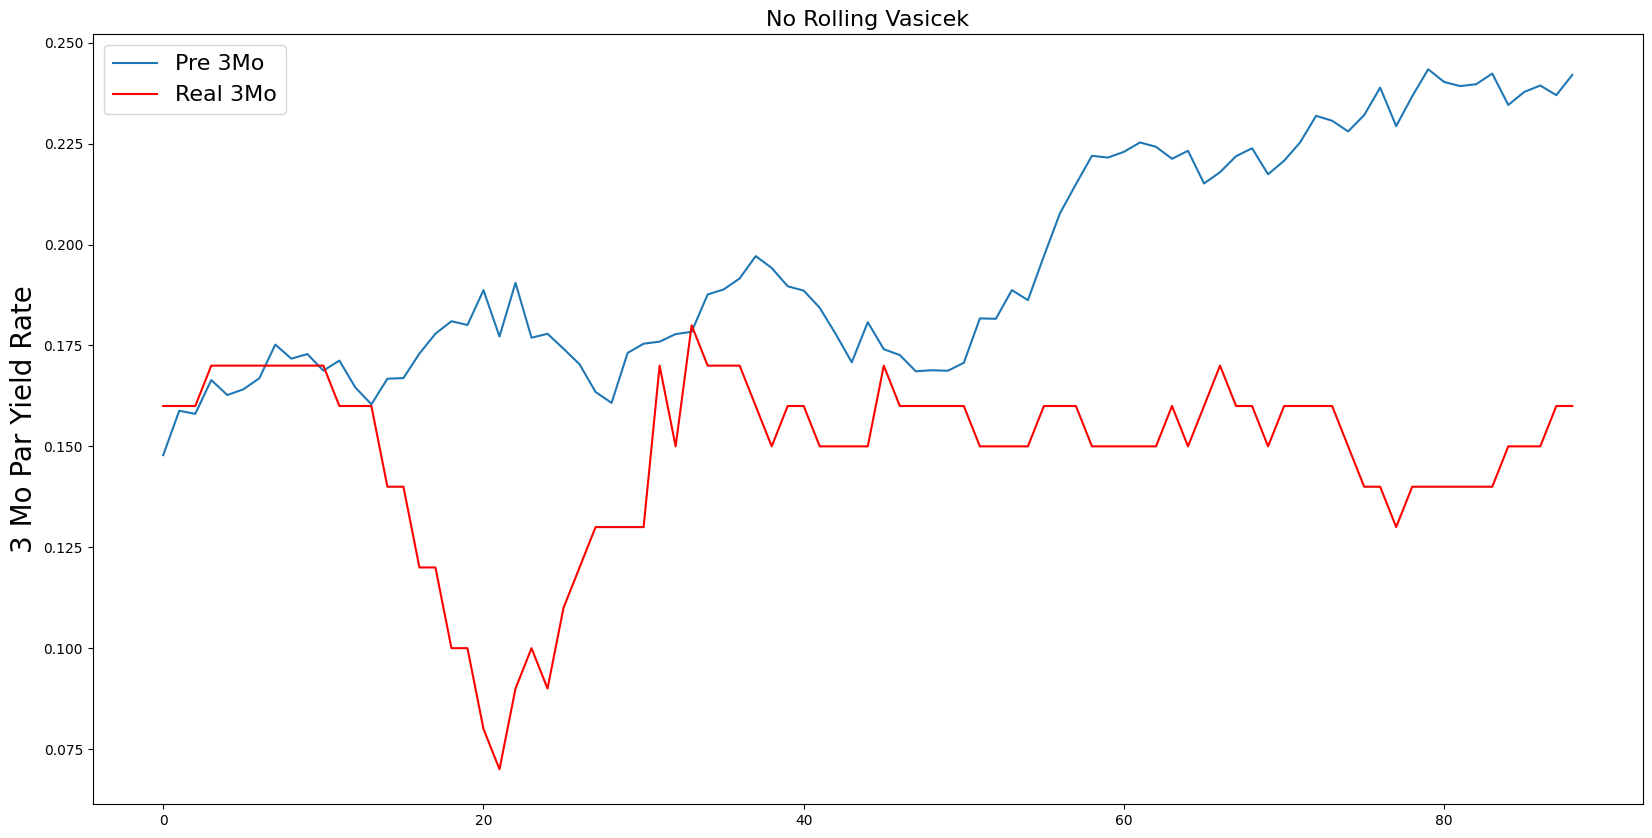

In [60]:
n = 0
plt.figure(figsize=(20,10))
l1,= plt.plot(DB['pred_1'][n])
# l2,= plt.plot(DB['pred_2'][n],'b-',markersize=4)
l3, = plt.plot(np.array(DB[((DB.index>=DB.index[0]) & (DB.index<DB.index[len(DB['pred_1'][0])]))]['3 Mo']),'r-',markersize=4)
plt.ylabel('3 Mo Par Yield Rate',fontsize = 20)
plt.legend(handles=[l1, l3], labels=['Pre 3Mo', 'Real 3Mo'], fontsize = 16)
plt.title('No Rolling Vasicek', fontsize = 16)

# Error Calculated : RMSE MSE SSE

In [52]:
DB

,3 Mo,3 Mo_shift,diff,a,b,sigma,pred_1
Date,,,,,,,
2010-05-13,0.16,0.16,0.00,0.1,0.1,0.1,"[[0.14783041573824215], [0.1588187149206115], ..."
2010-05-14,0.16,0.16,0.00,0.1,0.1,0.1,"[[0.15717865896853997], [0.15045158148921603],..."
2010-05-17,0.16,0.16,0.00,0.1,0.1,0.1,"[[0.15828828083570254], [0.16226220066759206],..."
2010-05-18,0.17,0.16,0.01,0.1,0.1,0.1,"[[0.16286697065861888], [0.15704797897916062],..."
2010-05-19,0.17,0.17,0.00,0.1,0.1,0.1,"[[0.1728588680958244], [0.17843931866102242], ..."
...,...,...,...,...,...,...,...
2023-05-31,5.52,5.55,-0.03,0.1,-0.1,0.1,"[[5.5462742245897605], [5.539218148223065], [5..."
2023-06-01,5.50,5.52,-0.02,0.1,-0.1,0.1,"[[5.511921451608736], [5.512465603518718], [5...."
2023-06-02,5.50,5.50,0.00,0.1,-0.1,0.1,"[[5.507639002044645], [5.508392737260204], [5...."


In [78]:
# MSE
MSE = np.sum((DB['pred_1'][n][:,0] - DB[((DB.index>=DB.index[0]) & (DB.index<DB.index[len(DB['pred_1'][0])]))]['3 Mo'])**2)/len(DB['pred_1'][n])

# RMSE
RMSE = np.sqrt(MSE)

# # MAPE
# MAPE = np.sum(np.abs((DB['pred_1']-DB['3 Mo'])/DB['3 Mo']))/len(DB)

In [79]:
MSE

0.0034267418022424757

In [64]:
np.sum((DB['pred_1'] - DB['3 Mo'])**2)

array([[ 2.44059361],
       [ 2.5423898 ],
       [ 2.67158675],
       [ 2.79458406],
       [ 2.92540976],
       [ 3.06613077],
       [ 3.21142072],
       [ 3.33905461],
       [ 3.47114901],
       [ 3.6210812 ],
       [ 3.77519094],
       [ 3.90643997],
       [ 4.0446874 ],
       [ 4.20196651],
       [ 4.40515676],
       [ 4.5346056 ],
       [ 4.69284054],
       [ 4.90262471],
       [ 5.05353445],
       [ 5.17266171],
       [ 5.32384357],
       [ 5.50496982],
       [ 5.67490189],
       [ 5.84437529],
       [ 6.01579203],
       [ 6.1553673 ],
       [ 6.34642285],
       [ 6.50152848],
       [ 6.72014329],
       [ 6.89828239],
       [ 7.13050217],
       [ 7.34437238],
       [ 7.55919264],
       [ 7.77158159],
       [ 7.93416304],
       [ 8.17335955],
       [ 8.41591078],
       [ 8.59909477],
       [ 8.85502866],
       [ 9.0596767 ],
       [ 9.28431744],
       [ 9.48367888],
       [ 9.64330601],
       [ 9.86817872],
       [10.07861034],
       [10

# Vacisek